<a href="https://www.kaggle.com/code/hendrimardani/stunting?scriptVersionId=181038977" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

2024-06-02 07:38:42.790468: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 07:38:42.790559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 07:38:42.903116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Umur (Bulan): Mengindikasikan usia balita dalam bulan. Rentang usia ini penting untuk menentukan fase pertumbuhan anak dan membandingkannya dengan standar pertumbuhan yang sehat.

Jenis Kelamin: Terdapat dua kategori dalam kolom ini, 'laki-laki' dan 'perempuan'. Jenis kelamin merupakan faktor penting dalam analisis pola pertumbuhan dan risiko stunting.

Tinggi Badan: Dicatat dalam centimeter, tinggi badan adalah indikator utama untuk menilai pertumbuhan fisik balita. Data ini memungkinkan peneliti untuk menentukan apakah pertumbuhan anak sesuai dengan standar usianya.

Status Gizi: Kolom ini dikategorikan menjadi 4 status - 'severely stunting', 'stunting', 'normal', dan 'tinggi'. 'Severely stunting' menunjukkan kondisi sangat serius, 'stunting' menunjukkan kondisi stunting, 'normal' mengindikasikan status gizi yang sehat, dan 'tinggi' menunjukkan pertumbuhan di atas rata-rata. Kategori ini membantu dalam identifikasi cepat dan intervensi bagi anak-anak yang berisiko atau mengalami masalah pertumbuhan.

# Data Understanding

In [2]:
data = pd.read_csv("/kaggle/input/stunting-balita-detection-121k-rows/data_balita.csv")
data

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted
...,...,...,...,...
120994,60,perempuan,100.600000,normal
120995,60,perempuan,98.300000,stunted
120996,60,perempuan,121.300000,normal
120997,60,perempuan,112.200000,normal


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur (bulan)       120999 non-null  int64  
 1   Jenis Kelamin      120999 non-null  object 
 2   Tinggi Badan (cm)  120999 non-null  float64
 3   Status Gizi        120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


In [4]:
data.describe()

,Umur (bulan),Tinggi Badan (cm)
count,120999.000000,120999.000000
mean,30.173803,88.655434
std,17.575119,17.300997
min,0.000000,40.010437
25%,15.000000,77.000000
50%,30.000000,89.800000
75%,45.000000,101.200000
max,60.000000,128.000000


In [5]:
data.isnull().sum()

Umur (bulan)         0
Jenis Kelamin        0
Tinggi Badan (cm)    0
Status Gizi          0
dtype: int64

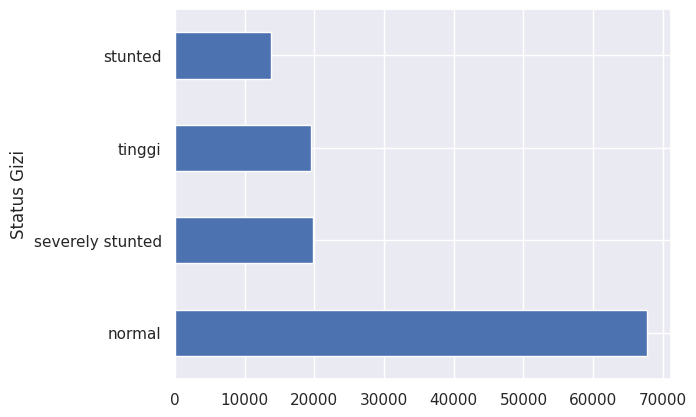

In [6]:
data["Status Gizi"].value_counts().plot.barh();

In [7]:
# Ganti kategori selain normal stunting

data["Status Gizi"].loc[data["Status Gizi"] != "normal"] = "stunted"

/tmp/ipykernel_34/3446678291.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["Status Gizi"].loc[data["Status Gizi"] != "normal"] = "stunted"
/tmp/ipykernel_34/3446678291.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

In [8]:
data

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,stunted
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,stunted
...,...,...,...,...
120994,60,perempuan,100.600000,normal
120995,60,perempuan,98.300000,stunted
120996,60,perempuan,121.300000,normal
120997,60,perempuan,112.200000,normal


In [9]:
data["Tinggi Badan (cm)"].min()

40.0104370037594

In [10]:
data["Status Gizi"].value_counts()

Status Gizi
normal     67755
stunted    53244
Name: count, dtype: int64

In [11]:
# jumlah_stunted = len(data[data["Status Gizi"] == "stunted"])
# jumlah_normal = len(data[data["Status Gizi"] == "normal"])
# print(f"Data normal stunted yang harus di hapus {jumlah_normal - jumlah_stunted} baris")

In [12]:
# print(f"Jumlah data yang harus dihapus tiap-tiap umur {np.round((jumlah_normal - jumlah_stunted) / data['Umur (bulan)'].nunique())}")

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur (bulan)       120999 non-null  int64  
 1   Jenis Kelamin      120999 non-null  object 
 2   Tinggi Badan (cm)  120999 non-null  float64
 3   Status Gizi        120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


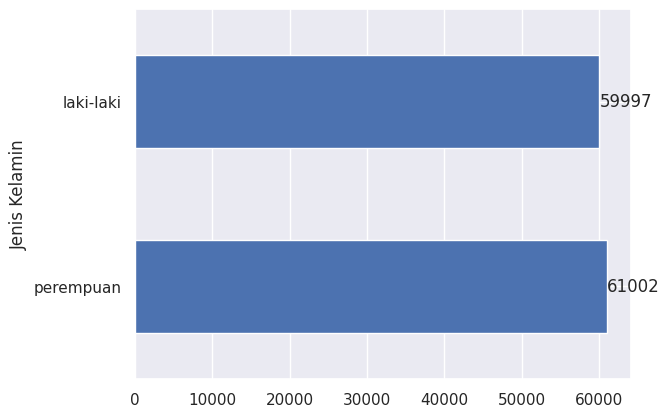

In [14]:
plot = data["Jenis Kelamin"].value_counts()
ax = plot.plot.barh()

for container in ax.containers:
    ax.bar_label(container)

In [15]:
sns.pairplot(data, hue="Status Gizi")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

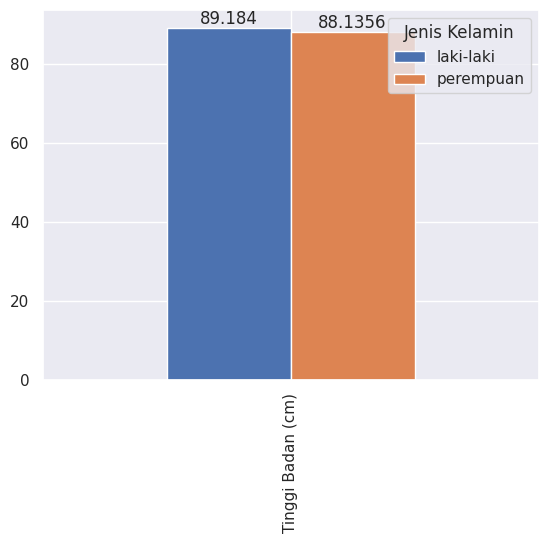

In [16]:
plot2 = pd.pivot_table(data, values="Tinggi Badan (cm)", columns="Jenis Kelamin", aggfunc="mean")
ax = plot2.plot.bar()

for container in ax.containers:
    ax.bar_label(container)

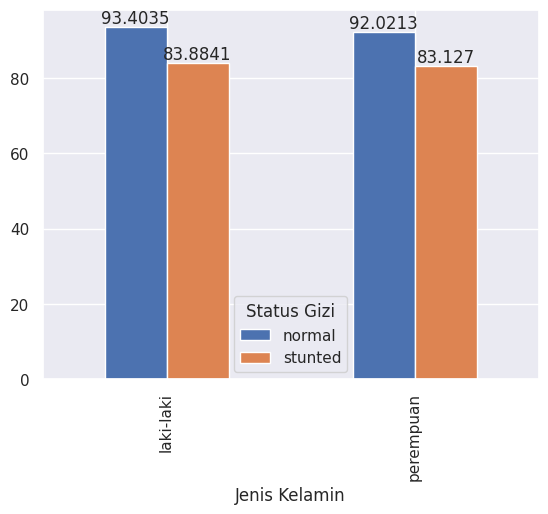

In [17]:
plot2 = pd.pivot_table(data, values="Tinggi Badan (cm)", columns="Status Gizi", index="Jenis Kelamin", aggfunc="mean")
ax = plot2.plot.bar()

for container in ax.containers:
    ax.bar_label(container)

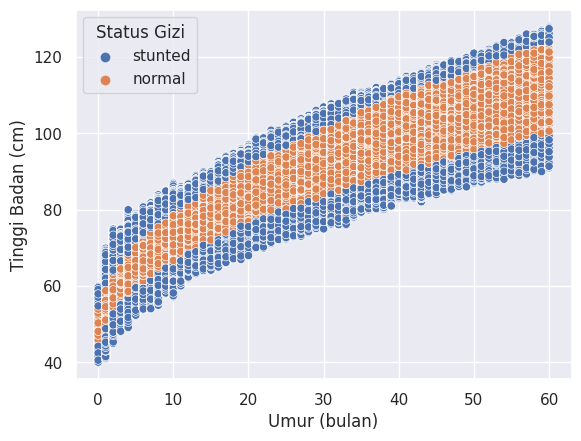

In [18]:
sns.scatterplot(data, x="Umur (bulan)", y="Tinggi Badan (cm)", hue="Status Gizi");

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

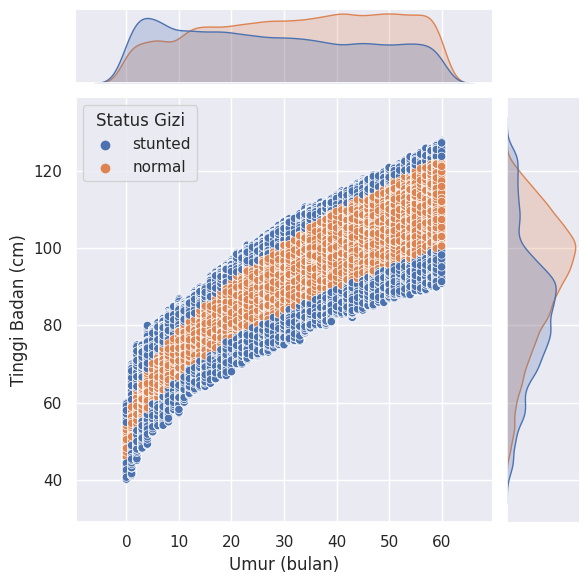

In [19]:
sns.jointplot(data=data, x="Umur (bulan)", y="Tinggi Badan (cm)", hue="Status Gizi")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


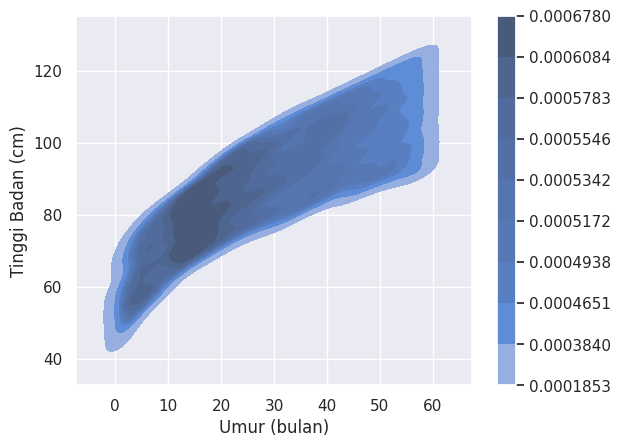

In [20]:
sns.kdeplot(data=data, x="Umur (bulan)", y="Tinggi Badan (cm)", fill=True, cbar=True);

# Data Preparation

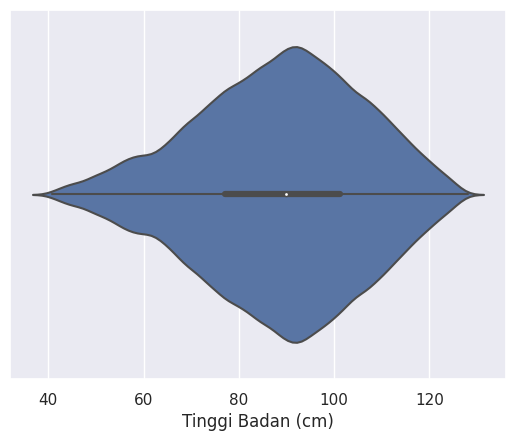

In [21]:
sns.violinplot(data=data, x="Tinggi Badan (cm)");

<Axes: xlabel='Umur (bulan)'>

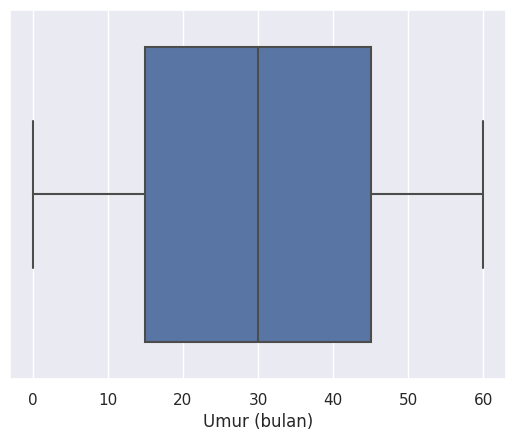

In [22]:
sns.boxplot(data=data, x="Umur (bulan)")

Dari hasil analisis diatas kita tidak memiliki outlier (nilai yang diatas atau dibawah ambang batas), sehingga kita bisa meneruskan ketahap transformasi data

In [23]:
# # 0 = laki-laki, 1 = perempuan
encoder_jk = LabelEncoder()
encoder_jk.fit(data["Jenis Kelamin"])
data["Jenis Kelamin"] = encoder_jk.transform(data["Jenis Kelamin"])


# 0 = normal, 1 = stunted
encoder_gizi = LabelEncoder()
encoder_gizi.fit(data["Status Gizi"])
encoder_gizi.transform(data["Status Gizi"])
data["Status Gizi"] = encoder_gizi.transform(data["Status Gizi"])

In [24]:
data

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,0,44.591973,1
1,0,0,56.705203,1
2,0,0,46.863358,0
3,0,0,47.508026,0
4,0,0,42.743494,1
...,...,...,...,...
120994,60,1,100.600000,0
120995,60,1,98.300000,1
120996,60,1,121.300000,0
120997,60,1,112.200000,0


In [25]:
# Convert tinggi badan ke bilangan bulat

data["Tinggi Badan (cm)"] = data["Tinggi Badan (cm)"].apply(lambda x: np.round(x))
data

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,0,45.0,1
1,0,0,57.0,1
2,0,0,47.0,0
3,0,0,48.0,0
4,0,0,43.0,1
...,...,...,...,...
120994,60,1,101.0,0
120995,60,1,98.0,1
120996,60,1,121.0,0
120997,60,1,112.0,0


# Modeling

In [26]:
X = data.iloc[:, :3]
y = data.iloc[:, -1]
X

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm)
0,0,0,45.0
1,0,0,57.0
2,0,0,47.0
3,0,0,48.0
4,0,0,43.0
...,...,...,...
120994,60,1,101.0
120995,60,1,98.0
120996,60,1,121.0
120997,60,1,112.0


In [27]:
# Normalisasi Data

min_max = MinMaxScaler()
X = min_max.fit_transform(X)
X

array([[0.        , 0.        , 0.05681818],
       [0.        , 0.        , 0.19318182],
       [0.        , 0.        , 0.07954545],
       ...,
       [1.        , 1.        , 0.92045455],
       [1.        , 1.        , 0.81818182],
       [1.        , 1.        , 0.79545455]])

In [28]:
# Spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(f"Data X latih {X_train.shape}", f"Data X test {X_test.shape}", f"Data Y latih {y_train.shape}, Data Y test {y_test.shape}")

Data X latih (96799, 3) Data X test (24200, 3) Data Y latih (96799,), Data Y test (24200,)


In [29]:
model = RandomForestClassifier()
model

RandomForestClassifier()

In [30]:
model.fit(X_train, y_train)

RandomForestClassifier()

In [31]:
X_test

array([[0.48333333, 1.        , 0.73863636],
       [0.73333333, 0.        , 0.64772727],
       [0.8       , 0.        , 0.77272727],
       ...,
       [0.6       , 1.        , 0.59090909],
       [0.75      , 1.        , 0.55681818],
       [0.15      , 1.        , 0.40909091]])

In [32]:
y_pred = model.predict(X_test)
y_pred

array([1, 0, 0, ..., 0, 1, 0])

In [33]:
pd.DataFrame({"y_aktual": y_test,
              "y_pred" : y_pred
             })

,y_aktual,y_pred
58779,1,1
87759,0,0
95718,0,0
82488,1,1
69602,0,0
...,...,...
35295,0,0
53290,1,1
72021,0,0
90061,1,1


# Evaluate Model

In [34]:
acc = accuracy_score(y_pred, y_test)

print(f"Accuracy model = {acc}")

Accuracy model = 0.9821900826446281


In [35]:
# Test Model

# Umur 30 bulan, laki-laki, tinggi badan 40 cm
# Umur 40 bulan, laki-laki, tinggi badan 25 cm
# Umur 50 bulan, perempuan, tinggi badan 100 cm

test = np.array([[10, 0, 40], [40, 0, 25], [50, 1, 100]])
model.predict(test)

array([1, 1, 1])

0 = normal, 1 = stunting
Berarti hasil diatas adalah

Umur 10 bulan, laki-laki, tinggi badan 40 cm model memprediksi stunting

Umur 40 bulan, laki-laki, tinggi badan 25 cm model memprediksi stunting

Umur 50 bulan, perempuan, tinggi badan 100 cm model memprediksi stunting

# Menggunakan Deep Learning

In [36]:
data

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,0,45.0,1
1,0,0,57.0,1
2,0,0,47.0,0
3,0,0,48.0,0
4,0,0,43.0,1
...,...,...,...,...
120994,60,1,101.0,0
120995,60,1,98.0,1
120996,60,1,121.0,0
120997,60,1,112.0,0


In [37]:
X = data.iloc[:, :3].values
y = data.iloc[:, 3:].values

print(f"data independen {X.shape}, data dependen {y.shape}")

data independen (120999, 3), data dependen (120999, 1)


In [38]:
# Normalisasi Data

min_max = MinMaxScaler()
X = min_max.fit_transform(X)
X

array([[0.        , 0.        , 0.05681818],
       [0.        , 0.        , 0.19318182],
       [0.        , 0.        , 0.07954545],
       ...,
       [1.        , 1.        , 0.92045455],
       [1.        , 1.        , 0.81818182],
       [1.        , 1.        , 0.79545455]])

In [39]:
# Spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(f"Data X latih {X_train.shape}", f"Data X test {X_test.shape}", f"Data Y latih {y_train.shape}, Data Y test {y_test.shape}")

Data X latih (96799, 3) Data X test (24200, 3) Data Y latih (96799, 1), Data Y test (24200, 1)


In [40]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

model_deep = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu", input_shape=(3,)),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
model_deep.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [42]:
history = model_deep.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[es], epochs=35)

Epoch 1/35
  95/3025 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5437 - loss: 3.6523

I0000 00:00:1717314063.519049     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3025/3025 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6992 - loss: 0.8788 - val_accuracy: 0.9517 - val_loss: 0.2677
Epoch 2/35
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9570 - loss: 0.2456 - val_accuracy: 0.9351 - val_loss: 0.2294
Epoch 3/35
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9622 - loss: 0.1938 - val_accuracy: 0.9747 - val_loss: 0.1608
Epoch 4/35
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9656 - loss: 0.1671 - val_accuracy: 0.9676 - val_loss: 0.1517
Epoch 5/35
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9685 - loss: 0.1491 - val_accuracy: 0.9622 - val_loss: 0.1473
Epoch 6/35
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9692 - loss: 0.1384 - val_accuracy: 0.9716 - val_loss: 0.1273
Epoch 7/35
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9707 - loss: 0.1299 - val_accuracy: 0.9652 - val_loss: 0.1347
Epoch 8/35
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9694 - loss: 0.1264 - val_accura

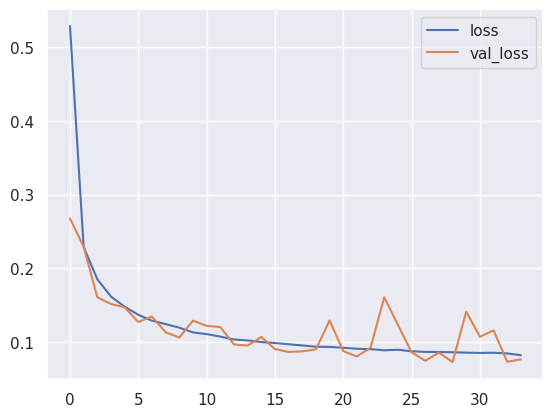

In [43]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])

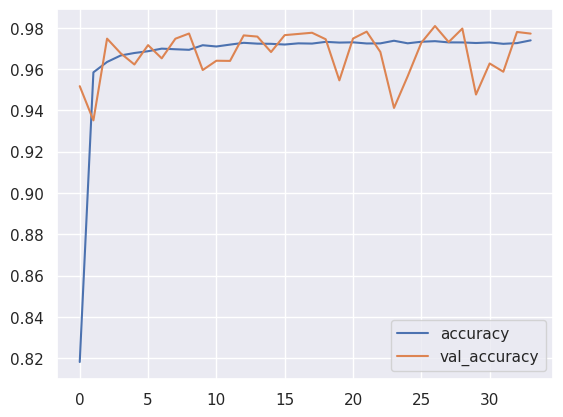

In [44]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

In [45]:
# Elemen pertama  loss, Elemen kedua akurasi
model_deep.evaluate(X_test, y_test)

757/757 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9779 - loss: 0.0755


[0.07666150480508804, 0.9771487712860107]

In [46]:
data

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,0,45.0,1
1,0,0,57.0,1
2,0,0,47.0,0
3,0,0,48.0,0
4,0,0,43.0,1
...,...,...,...,...
120994,60,1,101.0,0
120995,60,1,98.0,1
120996,60,1,121.0,0
120997,60,1,112.0,0


In [47]:
# Normalisasi test2 Rumus (Xi - Xmin) / (Xmax - Xmin)
# Test data dengan 1 data berisi
# umur (bulan) = 60, jk = laki-laki, tinggi badan = 110
umur_test_norm = (60 - data["Umur (bulan)"].min()) / (data["Umur (bulan)"].max() - data["Umur (bulan)"].min())
jk_test = 1
tinggi_test_norm = (110 - data["Tinggi Badan (cm)"].min()) / (data["Tinggi Badan (cm)"].max() - data["Tinggi Badan (cm)"].min())

test = np.array([[umur_test_norm, jk_test, tinggi_test_norm]])
np.round(model_deep.predict(test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


array([[0.]], dtype=float32)

0 model memprediksi bahwa kondisi normal, dan 1 memprediksi stunting

In [48]:
y_pred_deep = np.round(model_deep.predict(X_test))
y_pred_deep

757/757 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [49]:
pd.DataFrame({
    "y_pred_klasik": y_pred, 
    "y_pred_deep": y_pred_deep.flatten(),
    "y_aktual": y_test.flatten()
})

,y_pred_klasik,y_pred_deep,y_aktual
0,1,1.0,1
1,0,0.0,0
2,0,0.0,0
3,1,1.0,1
4,0,0.0,0
...,...,...,...
24195,0,0.0,0
24196,1,1.0,1
24197,0,0.0,0
24198,1,1.0,1


In [50]:
acc_deep = np.mean(history.history["accuracy"])

In [51]:
pd.DataFrame({"acc_klasik" : [acc], "acc_deep": [acc_deep]})

,acc_klasik,acc_deep
0,0.98219,0.966644


### Kesimpulan
Pada model klasik memang memiliki akurasi tinggi daripada model deep learning, tetapi model klasik rentan mengalami overfitting, maka dari itu kita 

akan menggunakan model deep learning supaya menghindari overfitting, hal ini bisa dilihat dari hasil training model deep learning itu sendiri.

Jika model mengalami overfitting akan terjadi gap antara loss dan val loss, begitu pula dengan accuracy dan val accuracy, sedangkan dalam training ini model tidak mengalami overfitting tetapi model mengalami good fit (model baik)

# Export model to tflite android

In [52]:
model_deep.export("model_stunting_regularizer")

Saved artifact at 'model_stunting_regularizer'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138239510701760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138239510706688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138239510701584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138239510696304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138239446421520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138239446420464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138239446425216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138239446421696: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [53]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/kaggle/working/model_stunting_regularizer") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 8, Total Ops 16, % non-converted = 50.00 %
 * 8 ARITH ops

- arith.constant:    8 occurrences  (f32: 8)



  (f32: 4)
  (f32: 1)
